In [1]:
#Boiler plate imports
import pandas as pd
import sys
from time import time
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm
from matplotlib.colors import LogNorm

#SBND imports
s0 = time()
sys.path.append('/exp/sbnd/app/users/brindenc/analyze_sbnd/pyana')
from sbnd.cafclasses.slice import CAFSlice
from sbnd.cafclasses.pfp import PFP

from pyanalib.panda_helpers import multicol_concat

#Constants
from sbnd.numu.numu_constants import *
from sbnd.constants import *
from sbnd.prism import PRISM_BINS

#Plotters
from sbnd.plotlibrary import makeplot
from sbnd.general import plotters

s1 = time()
print(f'SBND imports: {s1-s0:.2f} s')

%load_ext autoreload
%autoreload 2

SBND imports: 41.97 s


In [2]:
#Constants/variables
CUT_MODE = 'roc'
#DATA_DIR  = '/exp/sbnd/data/users/brindenc/analyze_sbnd/numu/v09_78_04_wc_pandora'
#DATA_DIR = '/exp/sbnd/data/users/brindenc/ML/test_fcl/debug_trackid/v4'
DATA_DIR = '/exp/sbnd/data/users/brindenc/analyze_sbnd/numu/v09_82_02_01_pds_gain'
FNAME = f'nom_processed_{CUT_MODE}.df'
HDR_FNAME = 'nom.df'
#FNAME = f'single_processed_{CUT_MODE}.df'
#FNAME = 'single_cut_cosmics_processed.df'
#HDR_FNAME = 'single.df'
#FNAME = f'all_processed_{CUT_MODE}.df'
#FNAME = 'all_processed_roc.df'
#HDR_FNAME = 'all.df'
#FNAME = 'test_processed.df'
#HDR_FNAME = 'test.df'
#NOM_POT = 0.6e20 # stats for first run
LABEL = 'SBND Work in Progress\n0.6e20 POT'
PLOT_DIR = f'Plots/reco_{plotters.day}_{CUT_MODE}/unfolding'
SAVE_PLOT = True

In [3]:
#Bins from MicroBooNE_CCInc_XSec_2DPcos_nu - https://github.com/NUISANCEMC/nuisance/blob/master/src/MicroBooNE/MicroBooNE_CCInc_XSec_2DPcos_nu.cxx
#Momentum bin edges - 
EdgesP = [
    [0.00, 0.18, 0.30, 0.45, 0.77, 2.50], # -1 to -0.5
    [0.00, 0.18, 0.30, 0.45, 0.77, 2.50], # -0.5 to 0
    [0.00, 0.18, 0.30, 0.45, 0.77, 2.50], # 0 to 0.27
    [0.00, 0.30, 0.45, 0.77, 2.50], # 0.27 to 0.45 - removed dummy
    [0.00, 0.30, 0.45, 0.77, 2.50], #  0.45 to 0.62 - removed dummy
    [0.00, 0.30, 0.45, 0.77, 2.50], # 0.62 to 0.76 - removed dummy
    [0.00, 0.30, 0.45, 0.77, 1.28, 2.50], # 0.76 to 0.86 
    [0.00, 0.30, 0.45, 0.77, 1.28, 2.50], # 0.86 to 0.94
    [0.00, 0.30, 0.45, 0.77, 1.28, 2.50], # 0.94 to 1
    ]
#Why tf does microboone use these bins? why? only god knows

In [4]:
#Get data and POT
pfp = PFP.load(f'{DATA_DIR}/{FNAME}','pfp'
               ,prism_bins=PRISM_BINS
               ,momentum_bins=MOMENTUM_BINS
               ,costheta_bins=COSTHETA_BINS
               ,pot=NOM_POT)
slc = CAFSlice.load(f'{DATA_DIR}/{FNAME}','slice'
                    ,prism_bins=PRISM_BINS
                    ,pot=NOM_POT)
hdr = pd.read_hdf(f'{DATA_DIR}/{HDR_FNAME}',key='hdr')
SAMPLE_POT = hdr.pot.sum()

#Scale to nominal POT
print(f'--scaled by {NOM_POT/SAMPLE_POT:.2f}')
pfp.scale_to_pot(NOM_POT,SAMPLE_POT)
slc.scale_to_pot(NOM_POT,SAMPLE_POT)

--scaled by 8.05
--scaling to POT: 7.45e+18 -> 6.00e+19
--scaling to POT: 7.45e+18 -> 6.00e+19


In [5]:
CUTS = ['cosmic','fv','trk','has_muon']
pur,eff,f1 = slc.get_pur_eff_f1(['cosmic','fv','trk','has_muon'])
pur,eff,f1

(array([0.22224323, 0.66998959, 0.81309471, 0.85877658, 0.92076491]),
 array([1.        , 0.7206205 , 0.61017594, 0.57319694, 0.49579174]),
 array([1.        , 0.69438333, 0.69717004, 0.68751007, 0.64453142]))

## 2. Apply cuts, get muons, assign bins

In [6]:
slc_cut = slc.copy()
for cut in CUTS:
    slc_cut.apply_cut(cut)
#concat best_muon df with weights df
df = multicol_concat(slc_cut.data.best_muon,pd.DataFrame(slc_cut.data.genweight),axis=1)
df = multicol_concat(df,pd.DataFrame(slc_cut.data.truth.event_type),axis=1)
muon = PFP(df
              ,pot=NOM_POT
              ,prism_bins=PRISM_BINS
              ,momentum_bins=MOMENTUM_BINS
              ,costheta_bins=COSTHETA_BINS)

In [7]:
#Assign costheta bins - we do this after cuts to save some time - may postprocess this in the future
muon.assign_costheta_bins()
muon.assign_costheta_bins(key='truth.p.costheta',assign_key='truth.costheta_bin')

#Momentum bin
muon.assign_momentum_bins()
muon.assign_momentum_bins(key='truth.p.genp.tot',assign_key='truth.momentum_bin')

9it [00:03,  2.27it/s]
9it [00:04,  2.23it/s]
9it [00:02,  3.95it/s]
9it [00:02,  3.85it/s]


## 2. Get Response Matrix

/tmp/ipykernel_32015/1504014331.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ticks,rotation=45)
/tmp/ipykernel_32015/1504014331.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ticks,rotation=45)


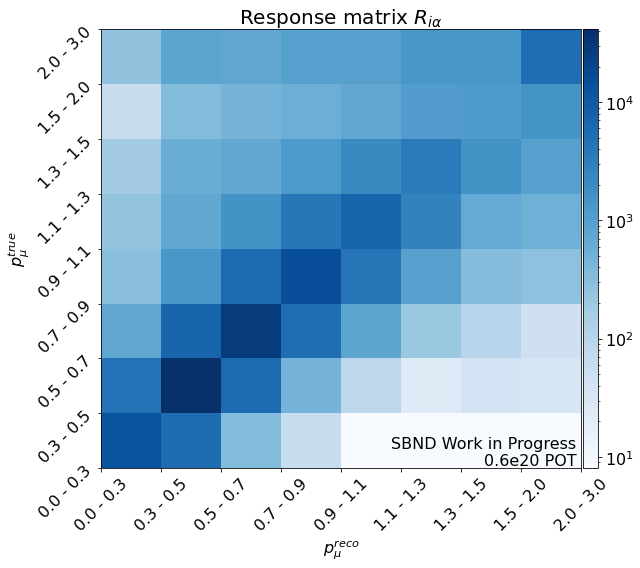

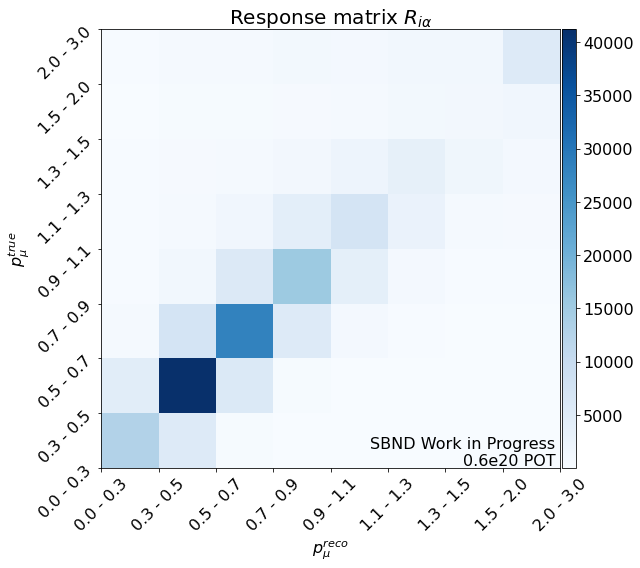

In [8]:
#For now use MOMENTUM_BINS
true = muon.data.truth.momentum_bin
reco = muon.data.momentum_bin
weights = muon.data.genweight

ticks = [f'{m} - {MOMENTUM_BINS[i+1]}' for i,m in enumerate(MOMENTUM_BINS[:-1])]
bins = np.arange(0,9,1)
fname = 'response_matrix_momentum'

for scale in ['log','linear']:
    if scale == 'log':
        norm = LogNorm()
        fname += '_log'
    else:
        norm = None
    fig,ax = plt.subplots(figsize=(9,8),tight_layout=True)
    fig,ax = makeplot.plot_hist2d(reco,true,xlabel=r'$p_\mu ^{reco}$',
                                ylabel=r'$p_\mu ^{true}$',
                                title=r'Response matrix $R_{i \alpha}$',
                                bins=bins,
                                colorbar=True,
                                weights=weights,
                                norm=norm,
                                fig=fig,
                                ax=ax)
    ax.set_yticklabels(ticks,rotation=45)
    ax.set_xticklabels(ticks,rotation=45)
    plotters.set_style(ax)
    plotters.add_label(ax,LABEL,where='bottomright',fontsize=16)
    if SAVE_PLOT:
        plotters.save_plot(fname,fig=fig,folder_name=PLOT_DIR)
        #plt.close()
        

/tmp/ipykernel_32015/2628747015.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ticks,rotation=45)
/tmp/ipykernel_32015/2628747015.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ticks,rotation=45)


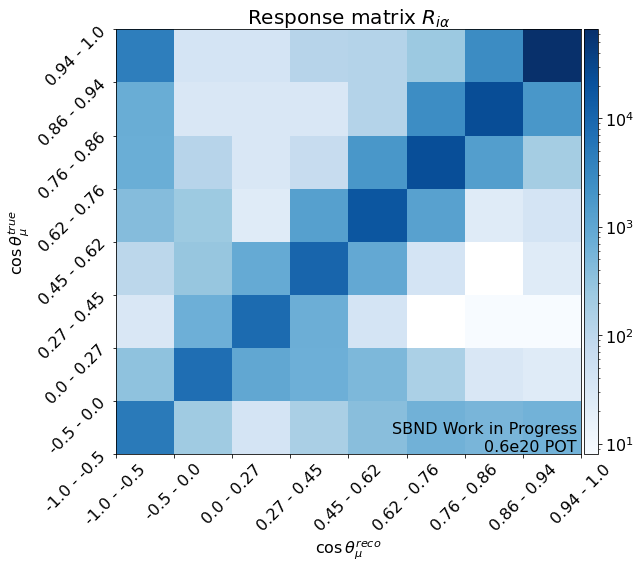

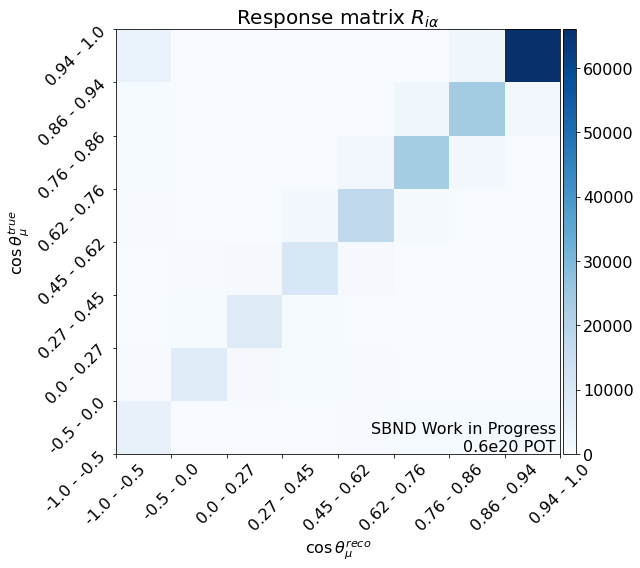

In [9]:
#Use COSTHETA bins
true = muon.data.truth.costheta_bin
reco = muon.data.costheta_bin
weights = muon.data.genweight

ticks = [f'{m} - {COSTHETA_BINS[i+1]}' for i,m in enumerate(COSTHETA_BINS[:-1])]
bins = np.arange(0,9,1)
fname = 'response_matrix_costheta'

for scale in ['log','linear']:
    if scale == 'log':
        norm = LogNorm()
        fname += '_log'
    else:
        norm = None
    fig,ax = plt.subplots(figsize=(9,8),tight_layout=True)
    fig,ax = makeplot.plot_hist2d(reco,true,xlabel=r'$\cos\theta_\mu ^{reco}$',
                                ylabel=r'$\cos\theta_\mu ^{true}$',
                                title=r'Response matrix $R_{i \alpha}$',
                                bins=bins,
                                colorbar=True,
                                weights=weights,
                                norm=norm,
                                fig=fig,
                                ax=ax)
    ax.set_yticklabels(ticks,rotation=45)
    ax.set_xticklabels(ticks,rotation=45)
    plotters.set_style(ax)
    plotters.add_label(ax,LABEL,where='bottomright',fontsize=16)
    if SAVE_PLOT:
        plotters.save_plot(fname,fig=fig,folder_name=PLOT_DIR)
        #plt.close()